<a href="https://colab.research.google.com/github/vlad-uve/CAE-MNIST/blob/main/notebooks/CAE_experiment_4(conv_depth).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder (CAE) — Experiment #4: Different Convolutional Depth

This notebook explores the impact of increasing the depth of the convolutional encoder-decoder architecture on reconstruction quality and training behavior when applied to MNIST digit images.

---

## 📌 Objective

To evaluate how adding more convolutional layers affects the model's ability to learn compact representations and reconstruct digit images. The goal is to assess whether deeper architectures offer meaningful improvements compared to the baseline CAE.

---

## 🔁 Experiment Workflow

1. Clone the project and configure dependencies  
2. Define multiple CAE variants with different convolutional depths  
3. Train each variant over 20 epochs using the Adam optimizer  
4. Analyze training and validation losses, and compare reconstruction quality with the baseline model  
5. Draw conclusions  
6. Export results to GitHub

---

## 📊 Key Findings

- Additional convolutional layers do not improve reconstruction quality on MNIST  
- The 2-layer model performs equally well with fewer parameters and simpler architecture  
- Deeper models introduce unnecessary complexity without meaningful performance gains  

---

## 1. 🔧 Setup

This section prepares the environment for running the experiment.

- Clone the GitHub repository  
- Import model classes and utility functions from `src/`  
- Import necessary libraries  
- Define constants

## 2. 🧠 Define Experiment Models

This section defines two alternative CAE architectures to evaluate the effect of increased convolutional depth.

- `experiment_4_model_1`: 2-layer encoder and decoder (shallow autoencoder)  
- `experiment_4_model_2`: 4-layer encoder and decoder (deep autoencoder)

🟩 **Baseline model:** 3-layer encoder and decoder

All other architectural and training parameters remain consistent with the baseline model, including:

- Filters: `[32, 32, 64]`
- Latent dimension: `32`
- Batch sizes: 32 (train) / 500 (validation)
- Activation: ReLU  
- Optimizer: Adam (`lr = 1e-3`)  
- Scheduler: `ReduceLROnPlateau`  
- Epochs: 20  

## 3. 🏋️‍♀️ Train Experiment Models

Each model variant is trained using the same `run_model_training()` function to ensure consistency.

For each configuration:
- A model is initialized with its respective number of encoder/decoder layers  
- The optimizer (`Adam`) and scheduler (`ReduceLROnPlateau`) are redefined  
- Training proceeds for 20 epochs with the same data loaders as the baseline  
- Training and validation losses are logged  
- Each model and its corresponding loss history are saved for analysis

This controlled setup isolates the effect of architectural depth.

## 4. 🔍 Results and Observations

This section presents the effect of convolutional depth on model learning and output quality.

### 4.1 📉 Loss Curve Analysis

- Both models converged within the first 10 epochs, confirming that 20 training epochs is sufficient  
- The **deeper model** and the **shallower model** showed the same training dynamic and final reconstruction loss as the **baseline model**
- Incorpotation of extra convolutional layers did not influence trainign dynamics


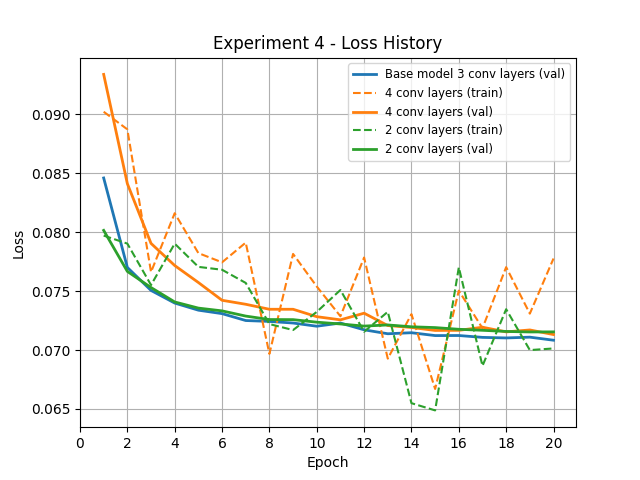

In [ ]:
display(Image(filename="CAE-MNIST/outputs/experiment_4_files/experiment_4_image_loss.png"))

### 4.2 📷 Reconstruction Quality Analysis
- Reconstructed images from models with 2, 3, and 4 convolutional layers are visually indistinguishable  
- All key features are consistently preserved across architectures, regardless of depth  
- Increasing the number of convolutional layers does not yield perceptible improvement in reconstruction quality

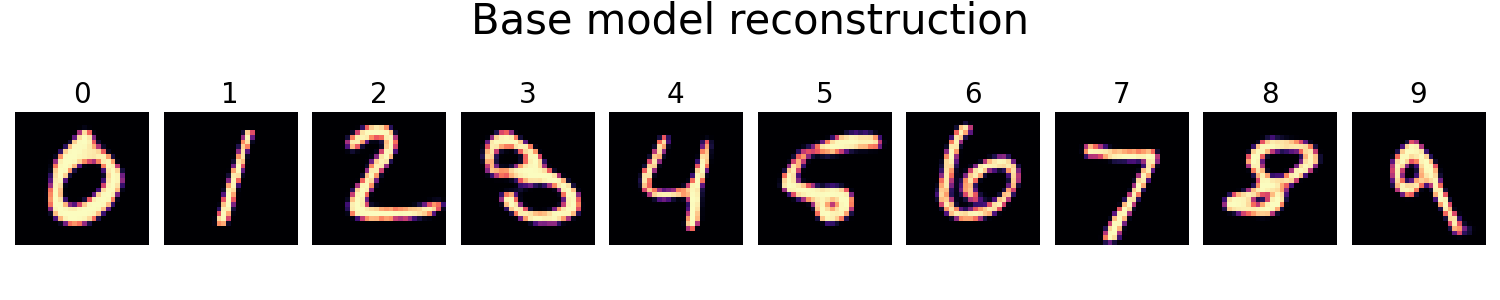

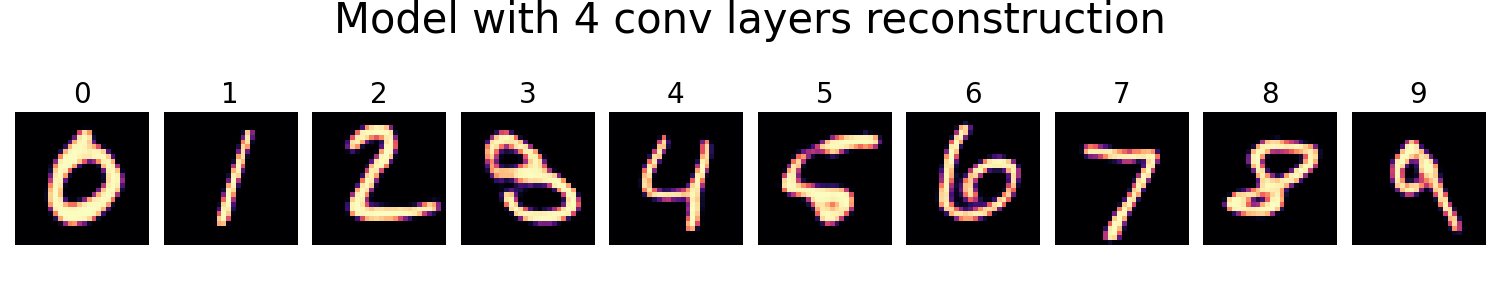

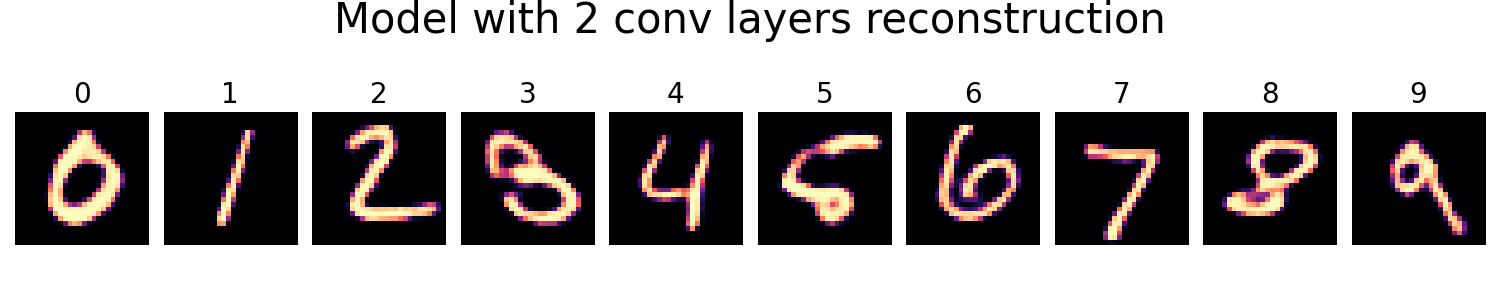

In [ ]:
display_reconstruction_images(4, 2)

### 4.3 🧮 Model Complexity Analysis
Notavbly the model with 4 convolutional layers increases model complexity, as reflected in the number of trainable parameters below. Notably the model with 2 layers has a bit less parameters tha the baseline model.

- Parameters of model with **4-layer encoder and decoder**: ~190K  
- Parameters of **base model** with 3-layer encoder and decoder: ~137K  
- Parameters of model with **2-layer encoder and decoder**: ~135K  

## 5. ✅ Conclusion

This experiment demonstrates that using more than 2 convolutional layers does not improve reconstruction quality of MNIST digits. Models with 2, 3, and 4 layers produce nearly identical outputs, with all key features well preserved.

Given that the 2-layer model matches the baseline in performance while requiring a bit fewer parameters (~135K vs. ~137K) and offering a simpler architectural setup, **it should be preferred** over deeper alternatives for this task. The added depth introduces unnecessary complexity without delivering meaningful gains in the scope of such simple images.

---
---

## 1. 🔧 Setup

In [ ]:
from getpass import getpass

# get repo url
token = getpass("Paste your GitHub token")
user_name = 'vlad-uve'
repo_name = 'CAE-MNIST'
repo_url = f"https://{token}@github.com/{user_name}/{repo_name}.git"

# clone the repo
!git config --global user.email "vladislav.yushkevich.uve@gmail.com"
!git config --global user.name "vlad_uve"
!git clone {repo_url}

# append system path
import sys
sys.path.append('/content/CAE-MNIST')

Paste your GitHub token··········
fatal: destination path 'CAE-MNIST' already exists and is not an empty directory.


In [ ]:
# import core model components
from src.model import AutoEncoder, Encoder, Decoder

# import training utilities
from src.train import train_model, validate_model, run_model_training

# import data loading functions
from src.data import get_train_dataloader, get_validation_dataloader

# import evaluation helpers
from src.evaluation import get_experiment_reconstructions, get_image_samples

# import plotting functions
from src.plotting import plot_digits_row, plot_experiment_reconstructions, plot_experiment_history, display_reconstruction_images

# import exporting functions
from src.export import save_experiment_files, export_experiment_files

In [ ]:
# OS and file utilities
import os
import shutil

# PyTorch core modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data loading and transformations
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Model summary utility
from torchsummary import summary

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Plotting
import matplotlib.pyplot as plt

# Import utility to display images directly in notebook
from IPython.display import Image, display

In [ ]:
# set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed for reproducibility
torch.manual_seed(0)

## 2. 🧠 Define Experiment Models



### 2.1 Define New Classes: DeepAutoEncoder and ShallowAutoEncoder

In [ ]:
# create DeepEncoder class for model with 4 convolutional layers as subclass of Encoder
class DeepEncoder(Encoder):
    def _build_layers(self):
        # 4-layer encoder architecture
        self.encn1 = nn.Conv2d(1, self.n_channels[0], self.kernel[0], self.stride, self.padding)
        self.encn2 = nn.Conv2d(self.n_channels[0], self.n_channels[1], self.kernel[1], self.stride, self.padding)
        self.encn3 = nn.Conv2d(self.n_channels[1], self.n_channels[2], self.kernel[2], self.stride, self.padding)
        self.encn4 = nn.Conv2d(self.n_channels[2], self.n_channels[3], self.kernel[3], self.stride, self.padding)

        # optional batch normalization
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(self.n_channels[0])
            self.bn2 = nn.BatchNorm2d(self.n_channels[1])
            self.bn3 = nn.BatchNorm2d(self.n_channels[2])
            self.bn4 = nn.BatchNorm2d(self.n_channels[3])
        else:
            self.bn1 = self.bn2 = self.bn3 = self.bn4 = nn.Identity()

        # flatten and fully connected bottleneck layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.n_channels[3] * 2 * 2, self.latent_dim)  # output is 2x2 assuming 28x28 input

    def forward(self, input_x):
        x = self.apply_activation(self.bn1(self.encn1(input_x)))
        x = self.apply_activation(self.bn2(self.encn2(x)))
        x = self.apply_activation(self.bn3(self.encn3(x)))
        x = self.apply_activation(self.bn4(self.encn4(x)))
        return self.fc1(self.flatten(x))


# create DeepDecoder class for model with 4 convolutional layers as subclass of Decoder
class DeepDecoder(Decoder):
    def _build_layers(self):
        # fully connected + unflatten
        self.fc1 = nn.Linear(self.latent_dim, self.n_channels[3] * 2 * 2)
        self.unflatten = nn.Unflatten(1, (self.n_channels[3], 2, 2))

        # 4-layer decoder architecture
        self.decn1 = nn.ConvTranspose2d(self.n_channels[3], self.n_channels[2], self.kernel[3]+1, self.stride, self.padding)
        self.decn2 = nn.ConvTranspose2d(self.n_channels[2], self.n_channels[1], self.kernel[2], self.stride, self.padding)
        self.decn3 = nn.ConvTranspose2d(self.n_channels[1], self.n_channels[0], self.kernel[1], self.stride, self.padding)
        self.decn4 = nn.ConvTranspose2d(self.n_channels[0], 1, self.kernel[0], self.stride, self.padding)

        # optional batch normalization
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(self.n_channels[2])
            self.bn2 = nn.BatchNorm2d(self.n_channels[1])
            self.bn3 = nn.BatchNorm2d(self.n_channels[0])
        else:
            self.bn1 = self.bn2 = self.bn3 = nn.Identity()

    def forward(self, encoded):
        x = self.unflatten(self.fc1(encoded))
        x = self.apply_activation(self.bn1(self.decn1(x)))
        x = self.apply_activation(self.bn2(self.decn2(x)))
        x = self.apply_activation(self.bn3(self.decn3(x)))
        x = self.decn4(x)
        return torch.sigmoid(x)


# create DeepAutoEncoder class for model with 4 convolutional layers
class DeepAutoEncoder(nn.Module):
    def __init__(self, n_channels, latent_dim, use_batch_norm=False, activation_func='relu', leaky_relu_slope=0.2):
        super(DeepAutoEncoder, self).__init__()

        kernel = [4, 4, 3, 3]
        stride = 2
        padding = 1

        self.encoder = DeepEncoder(n_channels, latent_dim, kernel, stride, padding,
                                   use_batch_norm, activation_func, leaky_relu_slope)
        self.decoder = DeepDecoder(n_channels, latent_dim, kernel, stride, padding,
                                   use_batch_norm, activation_func, leaky_relu_slope)

    def forward(self, input_x):
        encoded_x = self.encoder(input_x)
        decoded_x = self.decoder(encoded_x)
        return decoded_x, encoded_x

In [ ]:
# create ShallowEncoder class for model with 2 convolutional layers as subclass of Encoder
class ShallowEncoder(Encoder):
    def _build_layers(self):
        # 2-layer encoder architecture
        self.encn1 = nn.Conv2d(1, self.n_channels[0], self.kernel[0], self.stride, self.padding)
        self.encn2 = nn.Conv2d(self.n_channels[0], self.n_channels[1], self.kernel[1], self.stride, self.padding)

        # optional batch normalization layers after each conv
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(self.n_channels[0])
            self.bn2 = nn.BatchNorm2d(self.n_channels[1])
        else:
            self.bn1 = self.bn2 = nn.Identity()

        # flatten and fully connected bottleneck layer
        # assumes output is 7x7 after 2 conv layers on 28x28 input
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.n_channels[1] * 7 * 7, self.latent_dim)

    def forward(self, input_x):
        x = self.apply_activation(self.bn1(self.encn1(input_x)))
        x = self.apply_activation(self.bn2(self.encn2(x)))
        return self.fc1(self.flatten(x))


# create ShallowDecoder class for model with 2 convolutional layers as subclass of Decoder
class ShallowDecoder(Decoder):
    def _build_layers(self):
        # fully connected + unflatten to prepare for decoding
        self.fc1 = nn.Linear(self.latent_dim, self.n_channels[1] * 7 * 7)
        self.unflatten = nn.Unflatten(1, (self.n_channels[1], 7, 7))

        # 2-layer decoder architecture (reverse of encoder)
        self.decn1 = nn.ConvTranspose2d(self.n_channels[1], self.n_channels[0], self.kernel[1], self.stride, self.padding)
        self.decn2 = nn.ConvTranspose2d(self.n_channels[0], 1, self.kernel[0], self.stride, self.padding)

        # optional batch normalization
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(self.n_channels[1])
        else:
            self.bn1 = nn.Identity()

    def forward(self, encoded):
        x = self.unflatten(self.fc1(encoded))
        x = self.apply_activation(self.bn1(self.decn1(x)))
        x = self.decn2(x)
        return torch.sigmoid(x)  # use torch.sigmoid, not F.sigmoid


# create ShallowAutoEncoder class for model with 2 convolutional layers
class ShallowAutoEncoder(nn.Module):
    def __init__(self, n_channels, latent_dim, use_batch_norm=False, activation_func='relu', leaky_relu_slope=0.2):
        super(ShallowAutoEncoder, self).__init__()

        kernel = [4, 4]
        stride = 2
        padding = 1

        self.encoder = ShallowEncoder(n_channels, latent_dim, kernel, stride, padding,
                                      use_batch_norm, activation_func, leaky_relu_slope)
        self.decoder = ShallowDecoder(n_channels, latent_dim, kernel, stride, padding,
                                      use_batch_norm, activation_func, leaky_relu_slope)

    def forward(self, input_x):
        encoded_x = self.encoder(input_x)
        decoded_x = self.decoder(encoded_x)
        return decoded_x, encoded_x

### 2.2 Define Experiment Models

In [ ]:
# Load base model description
base_model_files_path = '/content/CAE-MNIST/outputs/base_model_files'
with open(os.path.join(base_model_files_path, 'base_description.txt'), 'r') as f:
    base_description = f.read()

# print baseline model description
print(base_description)

Baseline model configuration:
- Architecture: n_channels = [32, 32, 64], latent_dim = 32
- Batch normalization: False
- Activation function: ReLU
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training: 20 epochs
- Train batch size: 32
- Validation batch size: 500


In [ ]:
# define base parameters from the description
base_latent_dim=32
base_train_batch_size=32
base_validation_batch_size=500
base_num_epoch=20

# load training and validation dataloaders with base batch sizes
base_train_dataloader = get_train_dataloader(batch_size=base_train_batch_size, data_dir='../data')
base_validation_dataloader = get_validation_dataloader(batch_size=base_validation_batch_size, data_dir='../data')

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 615kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.92MB/s]


In [ ]:
# define experiment 4 description: testing deffect of different convolutional depth
experiment_4_description = """
Experiment 4: effect of convolutional depth
Two models tested:
experiment_4_model_1: DeepAutoEncoder with 4 conv layers (n_channels=[32, 32, 64, 128])
experiment_4_model_2: ShallowAutoEncoder with 2 conv layers n_channels=[32, 64])
Other parameters are the same as for the base line model
Trained for base_num_epoch epochs.
"""
print(experiment_4_description.strip())

# initialize experiment lists
experiment_4_losses = []
experiment_4_models = []

# define models with different convolution depth
experiment_4_model_classes = [
    DeepAutoEncoder(n_channels=[32, 32, 64, 64], latent_dim=base_latent_dim).to(device),
    ShallowAutoEncoder(n_channels=[32, 32], latent_dim=base_latent_dim).to(device)
]

Experiment 4: effect of convolutional depth
Two models tested:
experiment_4_model_1: DeepAutoEncoder with 4 conv layers (n_channels=[32, 32, 64, 128])
experiment_4_model_2: ShallowAutoEncoder with 2 conv layers n_channels=[32, 64])
Other parameters are the same as for the base line model
Trained for base_num_epoch epochs.


## 3. 🏋️‍♀️ Train Experiment Models

In [ ]:
# run experiments with each model
for model in experiment_4_model_classes:
    # define optimizer and scheduler
    base_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    base_scheduler = ReduceLROnPlateau(
        base_optimizer,
        mode='min',
        threshold=1e-3,
        patience=3,
        factor=0.5
    )

    # train model
    model, loss_history = run_model_training(
        model=model,
        train_dataloader=base_train_dataloader,
        validation_dataloader=base_validation_dataloader,
        optimizer=base_optimizer,
        scheduler=base_scheduler,
        num_epoch=base_num_epoch,
        device=device
    )

    # record results
    experiment_4_losses.append(loss_history)
    experiment_4_models.append(model)


TRAINING IS STARTED:
Epoch  1 | Train Loss: 0.0902 | Validation Loss: 0.0934
Epoch  2 | Train Loss: 0.0887 | Validation Loss: 0.0841
Epoch  3 | Train Loss: 0.0766 | Validation Loss: 0.0791
Epoch  4 | Train Loss: 0.0816 | Validation Loss: 0.0772
Epoch  5 | Train Loss: 0.0782 | Validation Loss: 0.0757
Epoch  6 | Train Loss: 0.0774 | Validation Loss: 0.0742
Epoch  7 | Train Loss: 0.0791 | Validation Loss: 0.0739
Epoch  8 | Train Loss: 0.0697 | Validation Loss: 0.0735
Epoch  9 | Train Loss: 0.0782 | Validation Loss: 0.0735
Epoch 10 | Train Loss: 0.0754 | Validation Loss: 0.0728
Epoch 11 | Train Loss: 0.0729 | Validation Loss: 0.0726
Epoch 12 | Train Loss: 0.0779 | Validation Loss: 0.0731
Epoch 13 | Train Loss: 0.0693 | Validation Loss: 0.0721
Epoch 14 | Train Loss: 0.0730 | Validation Loss: 0.0719
Epoch 15 | Train Loss: 0.0667 | Validation Loss: 0.0717
Epoch 16 | Train Loss: 0.0750 | Validation Loss: 0.0717
Epoch 17 | Train Loss: 0.0719 | Validation Loss: 0.0719
Epoch 18 | Train Loss: 0.0

## 4. 🔍 Results and Observations

### 4.1 📉 Loss Curve Analysis

In [ ]:
# import base loss
base_loss = torch.load('/content/CAE-MNIST/outputs/base_model_files/base_loss.pth')

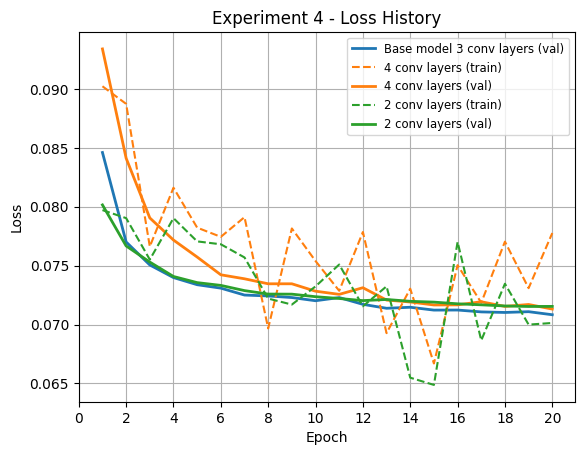

In [ ]:
# plot baseeline validation loss
plot_experiment_history([base_loss], label_list = ['Base model 3 conv layers'])

# plot training and validation losses for experiment 4 models
plot_experiment_history(
    loss_list=experiment_4_losses,
    label_list=['4 conv layers', '2 conv layers'],
    color=plt.get_cmap('tab10').colors[1:],
    to_plot_train=True,
)

# format plot
plt.xticks(range(0, base_num_epoch+1, 2))
plt.legend(fontsize='small')
plt.title('Experiment 4 - Loss History')
plt.grid()

# save plot
plt.savefig("/content/CAE-MNIST/outputs/experiment_4_files/experiment_4_image_loss.png")
plt.show()

In [ ]:
#manually add and push experiment 4 loss curve image to Git repository
!git -C /content/CAE-MNIST add outputs/experiment_4_files/experiment_4_image_loss.png
!git -C /content/CAE-MNIST commit -m "Update experiment 4 loss history curve"
!git -C /content/CAE-MNIST push origin main

[main 1dbb6ce] Update experiment 4 loss history curve
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite outputs/experiment_4_files/experiment_4_image_loss.png (98%)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 59.96 KiB | 14.99 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   84fd9c1..1dbb6ce  main -> main


### 4.2 📷 Reconstruction Quality Analysis

In [ ]:
# get sample images and labels
sample_images, sample_labels = get_image_samples(base_validation_dataloader)

# get reconstructed images from experiment 4
experiment_4_reconstructions=get_experiment_reconstructions(experiment_4_models, sample_images, device)

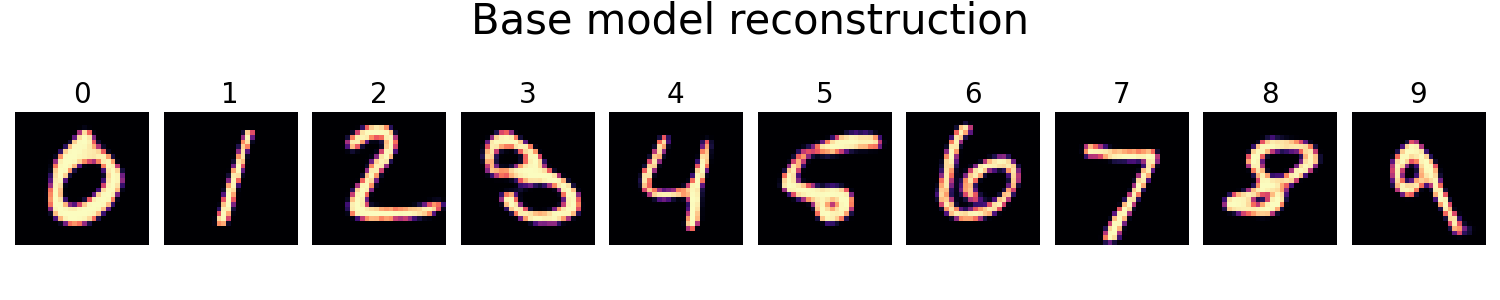

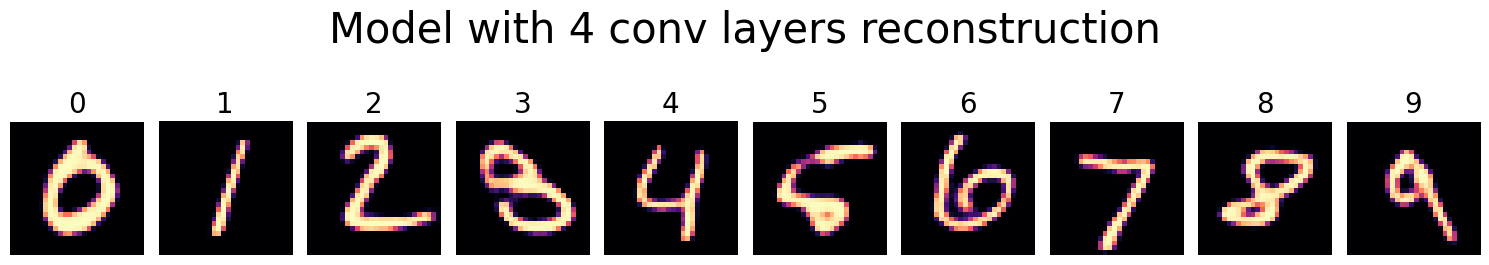

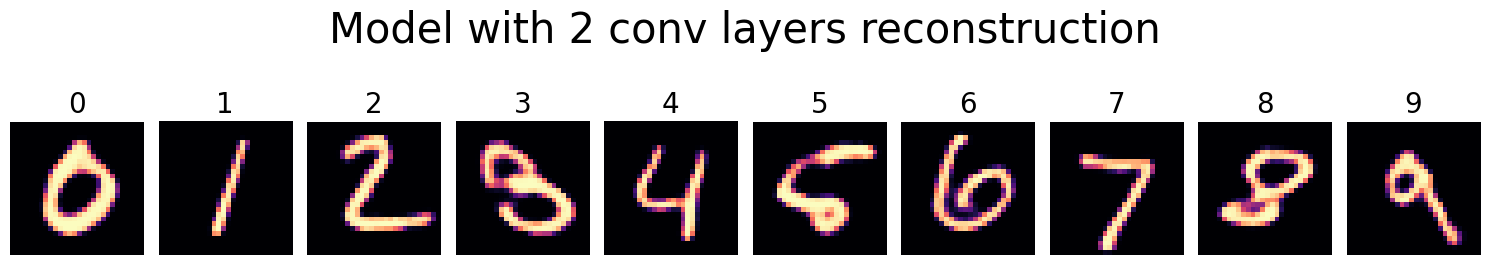

In [ ]:
# display original benchmark images
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png'))
print('\n')

# display reconstructions from experiment
experiment_4_reconstruction_figures = plot_experiment_reconstructions(
    experiment_4_reconstructions,
    sample_labels,
    title_list=['Model with 4 conv layers', 'Model with 2 conv layers']
    )

for idx, fig in enumerate(experiment_4_reconstruction_figures):
  fig.savefig(f"/content/CAE-MNIST/outputs/experiment_4_files/experiment_4_image_reconstruction_{idx+1}.png")

In [ ]:
#manually add and push experiment 1 reconstruction images to Git repository
for idx, _ in enumerate(experiment_4_reconstruction_figures):
  !git -C /content/CAE-MNIST add outputs/experiment_4_files/experiment_4_image_reconstruction_{idx+1}.png

!git -C /content/CAE-MNIST commit -m "Add experiment 4 reconstructed digits"
!git -C /content/CAE-MNIST push origin main

[main ef8f6b5] Add experiment 4 reconstructed digits
 2 files changed, 0 insertions(+), 0 deletions(-)
 rewrite outputs/experiment_4_files/experiment_4_image_reconstruction_1.png (99%)
 rewrite outputs/experiment_4_files/experiment_4_image_reconstruction_2.png (99%)
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 55.46 KiB | 13.87 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   1dbb6ce..ef8f6b5  main -> main


### 4.3 🧮 Model Complexity Analysis

In [ ]:
# dictionary of model parameters in experiment 45
experiment_4_param_counts = {}

for i, model in enumerate(experiment_4_models):
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_name = f"experiment_4_model_{i+1}"
    experiment_4_param_counts[model_name] = param_count

# print model paramets
print(experiment_4_param_counts)

{'experiment_4_model_1': 190049, 'experiment_4_model_2': 135841}


## 6. 📂 Export Experiment 4 Files

In [ ]:
save_experiment_files(
    experiment_name="experiment_4",
    models=experiment_4_models,
    losses=experiment_4_losses,
    param_counts_dict=experiment_4_param_counts,
    reconstructions=experiment_4_reconstructions,
    description_text=experiment_4_description
)

✅ Saved experiment_4 files to: /content/CAE_experiment_4_local


In [ ]:
export_experiment_files(
    experiment_name="experiment_4",
    model_count=len(experiment_4_models)
)

✅ Exported experiment_4 files to: outputs/experiment_4_files/


## Import Experiment 4 Files

In [ ]:
# Paths
outputs_path = '/content/CAE-MNIST/outputs/experiment_4_files'

# Storage lists
experiment_4_models = []
experiment_4_losses = []
experiment_4_reconstructions = []

# Load model weights, losses, and reconstructions
for idx, model in enumerate(experiment_4_model_classes):
    model_file = f'experiment_4_model_{idx+1}.pth'
    model_path = os.path.join(outputs_path, model_file)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    experiment_4_models.append(model)

    loss_file = f'experiment_4_loss_{idx+1}.pth'
    loss_path = os.path.join(outputs_path, loss_file)
    loss_history = torch.load(loss_path)
    experiment_4_losses.append(loss_history)

    reconstruction_file = f'experiment_4_reconstruction_{idx+1}.pth'
    reconstruction_path = os.path.join(outputs_path, reconstruction_file)
    reconstructed_images = torch.load(reconstruction_path)
    experiment_4_reconstructions.append(reconstructed_images)

    # Load param coun list
    param_counts_file = 'experiment_4_param_counts.pth'
    param_counts_path = os.path.join(outputs_path, param_counts_file)
    experiment_4_param_counts = torch.load(param_counts_path)

# Load experiment description
with open(os.path.join(outputs_path, 'experiment_4_description.txt'), 'r') as f:
    experiment_4_description = f.read()

print("✅ All Experiment 4 models, losses, reconstructed images and description loaded.")

✅ All Experiment 4 models, losses, reconstructed images and description loaded.


## Re-Clone Git Repository

In [ ]:
!rm -rf /content/CAE-MNIST
!git clone {repo_url}

Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 778 (delta 67), reused 52 (delta 39), pack-reused 663 (from 2)
Receiving objects: 100% (778/778), 30.14 MiB | 35.64 MiB/s, done.
Resolving deltas: 100% (391/391), done.
